# ZUM - implementacja klasyfikacji jednoklasowego (detekcja anomalii)
### Autorzy: Albert Ściseł, Mateusz Szczepanowski

# Część implementacyjna
**UWAGA:** żeby notatnik działał poprawnie należy dodać do folderu *data*, który musi znajdować się na poziomie notatnika, 2 zbiory danych, w następujący sposób:<br>
- pobrać zbiór danych Ionosphere https://archive.ics.uci.edu/dataset/52/ionosphere, nazwać go 52.csv i dodać do folderu data
- pobrać zbiór danych Spambase https://archive.ics.uci.edu/dataset/94/spambase, nazwać go 94.csv i dodać do folderu data

In [3]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [4]:
TARGET_CASTING = {
    52: {'g': 1, 'b': 0},
    }

HIDDEN_LAYERS_SIZE = {
    'first_linear': 256,
    'second_linear': 64
}

EVAL_THRESHOLD = 0.5

In [5]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_LAYERS_SIZE['first_linear']),
            nn.BatchNorm1d(HIDDEN_LAYERS_SIZE['first_linear']),
            nn.ReLU(),

            nn.Linear(HIDDEN_LAYERS_SIZE['first_linear'], HIDDEN_LAYERS_SIZE['second_linear']),
            nn.BatchNorm1d(HIDDEN_LAYERS_SIZE['second_linear']),
            nn.ReLU(),

            nn.Linear(HIDDEN_LAYERS_SIZE['second_linear'], 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def predict_proba(self, x):
        # to match function predict_proba in scikit-learn Random Forest model
        return self.model(x)

In [6]:
def calculate_auc(y_true, y_pred):
    auc_score = roc_auc_score(y_true, y_pred)
    return auc_score

def plot_roc(y_true, y_pred, auc_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
class OneClassClassifier:
    def __init__(self, train_df, n_of_splits, model_type="nn", batch_size=32):
        self.n_of_splits = n_of_splits
        self.train_df = train_df
        self.subsets = np.array_split(train_df, n_of_splits)
        self.input_dim = train_df.shape[1]
        self.batch_size = batch_size

        if model_type == "nn":
            self.models = [Perceptron(self.input_dim) for _ in range(n_of_splits)]
        elif model_type == "rf" or model_type == 'xgb':
            self.models = []
        else:
            raise("Invalid model param!")
        self.model_type = model_type
        self.models_eval_score = []

    def prepare_data_nn(self, idx):
        subsets = copy.deepcopy(self.subsets)
        for i, subset in enumerate(subsets):
            if i == idx:
                subset["target"] = 0
            else:
                subset["target"] = 1
        combined_df = pd.concat(subsets, ignore_index=True)

        features = torch.Tensor(combined_df.drop('target', axis=1).values)
        targets = torch.Tensor(combined_df["target"].values)

        dataset = TensorDataset(features, targets)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return dataloader
    
    def prepare_data_ensemble(self, idx):
        subsets = copy.deepcopy(self.subsets)
        for i, subset in enumerate(subsets):
            if i == idx:
                subset["target"] = 0
            else:
                subset["target"] = 1
        combined_df = pd.concat(subsets, ignore_index=True)

        # Return features and targets
        return combined_df.drop('target', axis=1).values, torch.Tensor(combined_df["target"].values)

    def train_models(self, X_eval, y_eval, selection_metric='acc', verbose=False):
        if self.model_type == "nn":
            for idx, model in enumerate(self.models):
                model.train()
                dataloader = self.prepare_data_nn(idx)
                criterion = nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
                for epoch in range(25):
                    for inputs, labels in dataloader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels.unsqueeze(1))
                        loss.backward()
                        optimizer.step()
                    if verbose:
                        print(f'Model {idx+1}: Epoch {epoch+1}, Loss: {loss.item():.4f}')
                model_score = self.evaluate(model, X_eval, y_eval, selection_metric)
                self.models_eval_score.append(model_score)

        if self.model_type == "rf":
            for idx in range(self.n_of_splits):
                X, y = self.prepare_data_ensemble(idx)
                model = RandomForestClassifier(max_depth=4, random_state=0)
                model.fit(X, y)
                self.models.append(model)
                if verbose:
                    print(f"Model {idx+1} is ready (RandomForest)")

                model_score = self.evaluate(model, X_eval, y_eval)
                self.models_eval_score.append(model_score)
        
        if self.model_type == "xgb":
            for idx in range(self.n_of_splits):
                X, y = self.prepare_data_ensemble(idx)
                params = {
                    'objective': 'binary:logistic',
                }
                model = xgb.XGBClassifier(**params)
                model.fit(X, y)
                self.models.append(model)
                if verbose:
                    print(f"Model {idx+1} is ready (XGBoost)")

                model_score = self.evaluate(model, X_eval, y_eval)
                self.models_eval_score.append(model_score)
        

    def evaluate(self, model, X_eval, y_eval, selection_metric='acc'):
        if self.model_type == 'nn':
            model.eval()
            features = torch.Tensor(X_eval.values)
            targets = torch.Tensor(y_eval.values)

            dataset = TensorDataset(features, targets)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

            all_preds = []
            all_probas = []
            for inputs, _ in dataloader:

                output = model(inputs)
                all_probas.append(output.detach().numpy())
                preds = (output > EVAL_THRESHOLD).int()
                all_preds.extend(preds)
            all_probas = np.concatenate(all_probas, axis=0)

        elif self.model_type == 'rf' or self.model_type == 'xgb':
            all_preds = model.predict(X_eval.values)
            all_probas = model.predict_proba(X_eval.values)[:, 1]

        if selection_metric == 'auc':
            return calculate_auc(y_eval.values, all_probas)
        return accuracy_score(y_eval.values, all_preds)

    def get_top_models(self, fraction):
        combined = list(zip(self.models, self.models_eval_score))
        sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
        num_models_to_select = max(int(len(sorted_combined) * fraction), 1)
        top_models = [item for item, value in sorted_combined[:num_models_to_select]]
    
        return top_models

    def predict(self, input_samples, best_models_fraction=0.15, threshold=0.5):
        if self.model_type == 'nn':
            for model in self.models:
                model.eval()

        top_models = self.get_top_models(best_models_fraction)

        output_preds = []
        output_probs = []
        for sample in input_samples:
            if self.model_type == 'nn':
                sample = torch.Tensor(sample).reshape(1, -1)
                predictions = [model.predict_proba(sample) for model in top_models]
                average_prediction = torch.mean(torch.stack(predictions), dim=0)
                predicted_class = (average_prediction > threshold).int().item()
                output_probs.append(1 - average_prediction.item())
            elif self.model_type == 'rf' or self.model_type == 'xgb':
                sample = sample.reshape(1, -1)
                predictions = [model.predict_proba(sample) for model in top_models]
                average_prediction = np.mean(predictions, axis=0)[0]
                predicted_class = 1 if average_prediction[1] >= threshold else 0
                output_probs.append(average_prediction[1])
            
            output_preds.append(predicted_class)
        # Return avg_probability, predicted_class based on threshold
        return output_preds, output_probs
    
    def full_predict(self, input_samples, threshold=0.5):
        if self.model_type == 'nn':
            for model in self.models:
                model.eval()

        output_preds = []
        for sample in input_samples:
            if self.model_type == 'nn':
                sample = torch.Tensor(sample).reshape(1, -1)
                predictions = [model.predict_proba(sample) for model in self.models]
                average_prediction = torch.mean(torch.stack(predictions), dim=0)
            elif self.model_type == 'rf' or self.model_type == 'xgb':
                sample = sample.reshape(1, -1)
                predictions = [model.predict_proba(sample) for model in self.models]
                average_prediction = np.mean(predictions, axis=0)
            predicted_class = (average_prediction > threshold).int()

            output_preds.append(predicted_class.item())

        # Return avg_probability, predicted_class based on threshold
        return average_prediction, predicted_class.item()

In [8]:
def get_data(id: int):
    data = pd.read_csv(f"data/{id}.csv", header=None)

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    if y.dtype != 'int64':
        y = y.replace(TARGET_CASTING[id])

    X["target"] = y.values

    return X

In [9]:
def main(cli_args=None, just_test_dataset_info=False):
    if cli_args is None and not just_test_dataset_info:
        parser = argparse.ArgumentParser()
        parser.add_argument('--dataset_id', required=True, default=52, choices=[52, 94], type=int)
        parser.add_argument('--model_type', required=True, default='nn', choices=['nn', 'svm', 'if', 'rf', 'xgb'], type=str)
        parser.add_argument('--noise', required=False, default=0.16, type=float)
        parser.add_argument('--splits', required=False, default=3, type=int)
        parser.add_argument('--val_size', required=False, default=0.15, type=float)
        parser.add_argument('--best_models_fraction', required=False, default=0.5, type=float)
        parser.add_argument('--selection_metric', required=False, default='acc', choices=['acc', 'auc'], type=str)

        cli_args = parser.parse_args()
    
    if just_test_dataset_info:
        X = get_data(52)

        X, X_test = train_test_split(X, test_size=0.15, stratify=X['target'], random_state=2137)
        print(f"Test Dataset Class 0 -> {len(X_test[X_test['target'] == 0])}")
        print(f"Test Dataset Class 1 -> {len(X_test[X_test['target'] == 1])}")
        return
    
    X = get_data(cli_args.dataset_id)

    X, X_test = train_test_split(X, test_size=0.15, stratify=X['target'], random_state=2137)
    model_type = cli_args.model_type

    X_normal = X[X["target"] == 1]
    X_anomaly = X[X["target"] == 0]

    X_normal_noise = X_anomaly.sample(frac=cli_args.noise)
    X_normal_noise = pd.concat([X_normal, X_normal_noise])

    y_normal_noise = X_normal_noise["target"]
    X_normal_noise.drop(columns=["target"], inplace=True)
    X_anomaly.drop(columns=["target"], inplace=True)

    y_test = X_test["target"]
    X_test.drop(columns=["target"], inplace=True)

    if model_type == 'if':
        model = IsolationForest(random_state=42)
        model.fit(X_normal_noise.values)
        y_pred = model.predict(X_test.values)
        y_pred = np.where(y_pred == -1, 0, 1)

        scores = model.decision_function(X_test.values)
        min_score = min(scores)
        max_score = max(scores)
        y_proba = (scores - min_score) / (max_score - min_score)

    elif model_type == 'svm':
        model = OneClassSVM(gamma='auto', kernel="rbf")
        model.fit(X_normal_noise.values)
        y_pred = model.predict(X_test.values)
        y_pred = np.where(y_pred == -1, 0, 1)

        scores = model.decision_function(X_test.values)
        min_score = min(scores)
        max_score = max(scores)
        y_proba = (scores - min_score) / (max_score - min_score)

    else:
        X_train, X_eval, _, y_eval = train_test_split(
            X_normal_noise,
            y_normal_noise,
            test_size=cli_args.val_size,
            random_state=42,
        )

        model = OneClassClassifier(
            n_of_splits = cli_args.splits,
            train_df = X_train,
            model_type = model_type,
        )

        model.train_models(
            X_eval = X_eval,
            y_eval = y_eval,
            selection_metric=cli_args.selection_metric
        )

        y_pred, y_proba = model.predict(X_test.values, cli_args.best_models_fraction)
    auc_score = calculate_auc(y_test, y_proba)
    plot_roc(y_test, y_proba, auc_score)

# Część sprawozdania

## 1. Założenia projektu
Projekt polegał na zaimplementowaniu i przetestowaniu modelu klasyfikacji jednoklasowej, który oparty jest na zespołach dowolnych klasyfikatorów binarnych.
Celem takiego modelu jest nauczenie się rozpoznawania nowych instancji, które należą do tej klasy i odróżnianie ich od wszystkich innych instancji, które są uznawane za anomalie lub instancje niezgodne z klasą docelową. 

W naszym projekcie postanowiliśmy przetestować różne modele wchodzące w skład zespołu modeli klasyfikujących oraz porównać stworzone przez nas rozwiązanie do istniejących rozwiązań klasyfikacji jednoklasowej, np. lasu izolacyjnego.

## 2. Idea działania
Zbiór danych należy początkowo podzielić na N równolicznych zbiorów w sposób losowy. Następnie uczymy N klasyfikatorów binarnych w sposób one-vs-rest, gdzie przykłady z n-tego zbioru będą klasyfikowane jako 0 (anomalie) a pozostałe dane jako 1. Kolejnym etapem jest wybór najlepszych modeli na podstawie pewnej metryki (np. AUC). Mając tak przygotowany model typu ensemble, możemy robić predykcję nowych próbek danych korzystając z soft-votingu, tj. uśrednione wartości prawdopodobieństw z modeli dla danej klasy.

## 3. Opis implementacji
- Przygotowanie danych<br>
Jeżeli chodzi o dane, postanowiliśmy wykorzystać 2 zbiory danych, które dostępne są pod linkiem https://archive.ics.uci.edu/. Prace przeprowadziliśmy na zbiorze „Spambase” oraz „Ionsphere”. Oba zbiory są zbiorami o 2 targetach. Dzięki temu możemy traktować jedną klasę jako anomalię, a drugą jako próbkę „normalną”.<br>W zbiorach danych należało ujednolicić wartości w kolumnach, przykładowo zamienić wartości w kolumnie celu na wartości binarne. Dodatkowo daliśmy możliwość zdefiniowania ilości szumu w danych, tj. ile % anomalii jest w zbiorze uczącym. W celu zbadania jakości rozwiązania podzieliliśmy zbiór danych na uczący i testowy.<br><br>
- Implementacja modelu<br>
Zaimplementowany przez nas model można zobaczyć wyżej. Widnieje on jako klasa OneClassClassifier. Dodaliśmy mozliwość wyboru jaki typ modelu wchodzi w skład modeli. Skupiliśmy się głównie na analizie sieci neuronowej, która została przez nas zaimplementowana jako klasa Perceptron, oraz lasu losowego, gdzie skorzystalismy z gotowej implementacji z biblioteki sklearn.

## 4. Środowisko programistyczne
Do realizacji projektu wykorzystaliśmy język programowania Python wraz z jego licznymi bibliotekami, w tym:<br>
- **Pandas** - używana do manipulacji i analizy danych, oferuje struktury danych takie jak DataFrame, które ułatwiają obsługę dużych zestawów danych. Wykorzystaliśmy tą bibliotekę głównie do wczytywania, czyszczenia, przekształcania i analizy danych.
- **Scikit-learn** – bardzo popularna biblioteka do uczenia maszynowego. Wykorzystaliśmy z niej m. in. metodę do podziału zbioru danych oraz liczne modele klasyfikacji, m. in. las izolacyjny (w celu porównania do naszego rozwiązania) oraz modele klasyfikacji binarnej, które wchodziły w skład naszej implementacji.
- **XGBoost** – biblioteka w pythonie, która implementuje model Extreme Gradient Boosting. Wykorzystany przez nas jako jeden z możliwych modeli klasyfikacji binarnej.
- **PyTorch** – biblioteka służąca do tworzenia głębokich sieci neuronowych. Za jej pomocą zaimplementowaliśmy klasyfikator binarny bazujący na sieci neuronowej (klasa Perceptron).

## 5. Przeprowadzone eksperymenty
Badanymi przez nas elementami są przede wszystkim następujące zmienne:
- model klasyfikacji binarnej wchodzący w skład zespołu klasyfikatorów
- ilość podziałów zbioru uczącego
- procent wyselekcjonowanych modeli
- metryka podczas selekcji modeli (dokładność oraz AUC)
- procent „zanieczyszczenia” danych (jaki procent anomalii jest wśród danych normalnych zbiorze uczącym)

## 6. Istotne założenia
Dobór odpowiedniej wartości progu jest dosyć trudnym zadaniem i zdecydowaliśmy, że lepszą metryką do oceny modeli będzie wartość AUC, która pozwala nam na ewaluacje klasyfikatora bez konieczności ustawiania wartości progu (odpowiednie dobranie wartości progu jest dosyć trudnym zadaniem dla tego typu zadania). Jedynym problemem z takim podejściem jest fakt, że modele, które będziemy porównywać nie zawsze zwracają wartości prawdopodobieństw. Chodzi tutaj o las izolacyjny oraz jednoklasowy SVM. Postanowiliśmy więc wykorzystać pewne przybliżenie, jakim jest zastosowanie funkcji o nazwie decision_funcion() a następnie znormalizowanie wyników, żeby były z przedziału wartości od 0 do 1.

## 7. Eksperymenty
**Uwagi do eksperymentów**<br>
Zbiór testowy jest wydzielony ze zbioru treningowego. Stanowi on 15% wszystkich danych. Ważny jest fakt, że stosując parametr *seed* zawsze dostajemy jednakowy zbiór testowy, co pozwala obiektywnie oceniać eksperymenty. W zbiorze o id 52, na którym przeprowadzamy eksperymenty, mamy 19 przykładów klasy 0, oraz 34 przykłady klasy 1.


In [10]:
main(just_test_dataset_info=True)

Test Dataset Class 0 -> 19
Test Dataset Class 1 -> 34


In [11]:
# Defaultowe argumenty
args = argparse.Namespace(
    dataset_id=52,
    model_type='nn',
    noise=0,
    splits=10,
    val_size=0.15,
    best_models_fraction=0.5,
    selection_metric='acc'
)

### Wybór modelu wchodzącego w skład naszego klasyfikatora

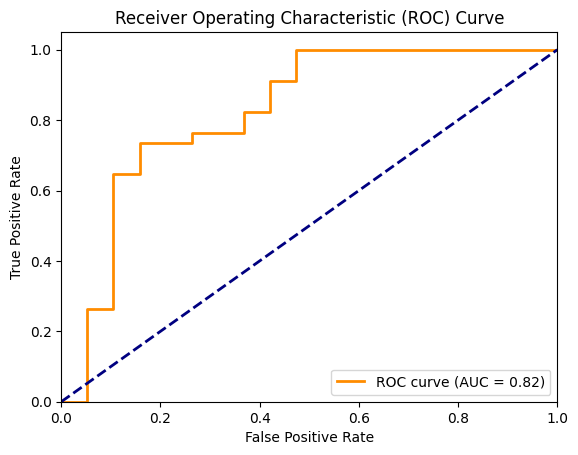

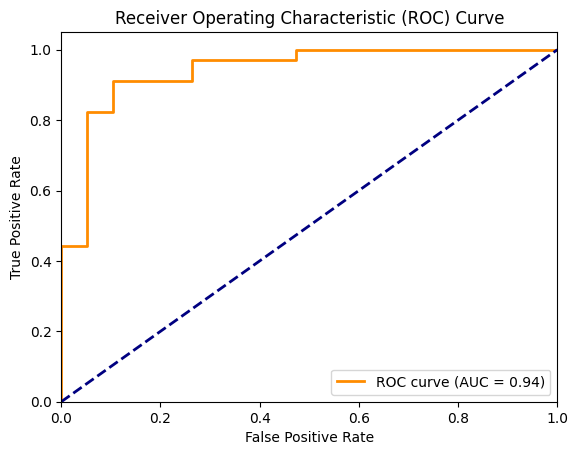

In [12]:
# Wybór sieci neuronowej
args.model_type = "nn"
main(args)

# Wybór lasu losowego
args.model_type = "rf"
main(args)

**WNIOSKI**<br>Wybór modeli klasyfikacji binarnej ma kluczowe znaczenie. Zaimplementowana przez nas sieć neuronowa daje gorsze wyniki niż las losowy. Może to wynikać przede wszystkim z tego, że sieć neuronowa gorzej sobie radzi z niezbalansowanym zbiorem danych niż podejście drzewiaste. Mimo wszystko widać, że obie metody działają i osiągają zadowalające wyniki.

### Wpływ ilości podziałów na otrzymany wynik 

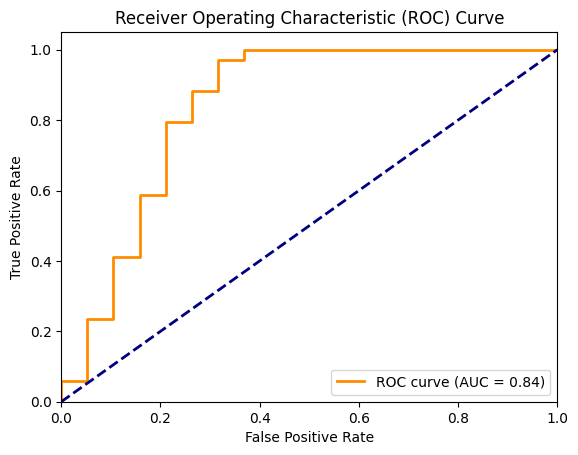

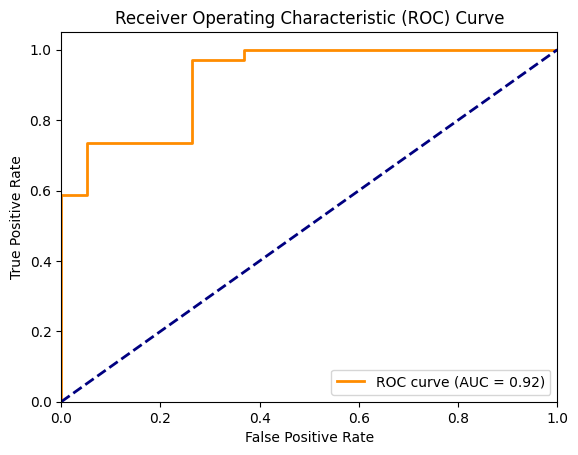

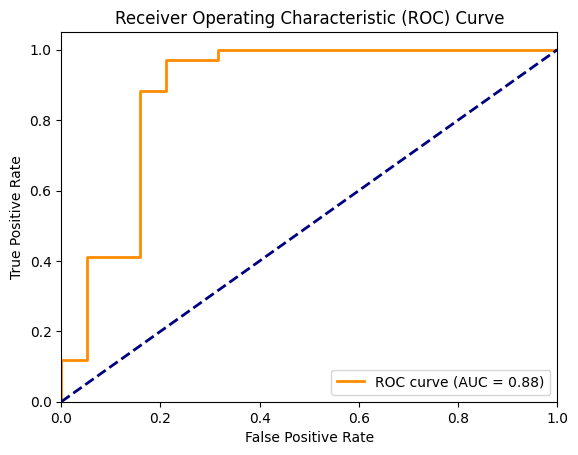

In [15]:
# Dla sieci neuronowej
args.model_type = "nn"
args.splits = 10
main(args)

args.splits = 30
main(args)

args.splits = 100
main(args)

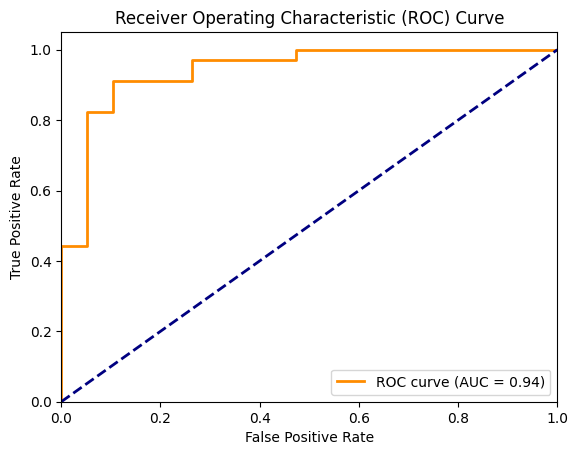

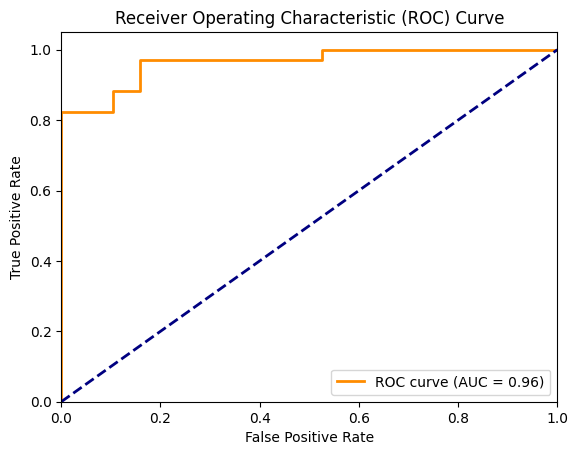

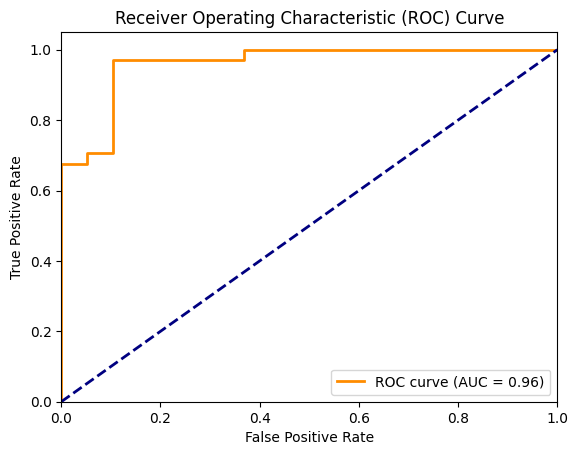

In [16]:
# Dla lasu losowego
args.model_type = "rf"
args.splits = 10
main(args)

args.splits = 30
main(args)

args.splits = 100
main(args)

**WNIOSKI**<br>
Większa ilość podziałów zazwyczaj przyczynia się do uzyskania lepszych wyników. Dla sieci neuronowej wartości AUC są lepsze dla większej ilości podziałów, najlepiej sprawdza się natomiast w przypadku liczby podziałów równej 30. Dla lasu losowego wynik jest bardzo podobny, większa liczba podziałów to lepsze rezultaty, natomiast nie widzimy różnicy dla wyników przy 100 oraz 30 splitach. Różnica między wynikami dla tych modeli może to wynikać z faktu, że im więcej podziałów tym bardziej niezbalansowany jest zbiór danych, a rozwiązania drzewiaste lepiej sobie radzą z tym problemem.

### Wpływ zanieczyszczenia danych na wyniki

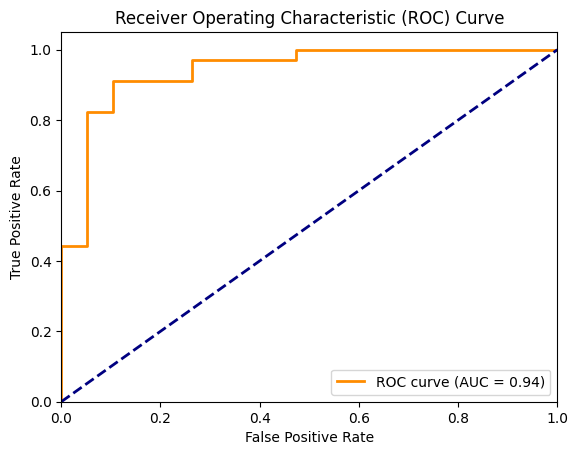

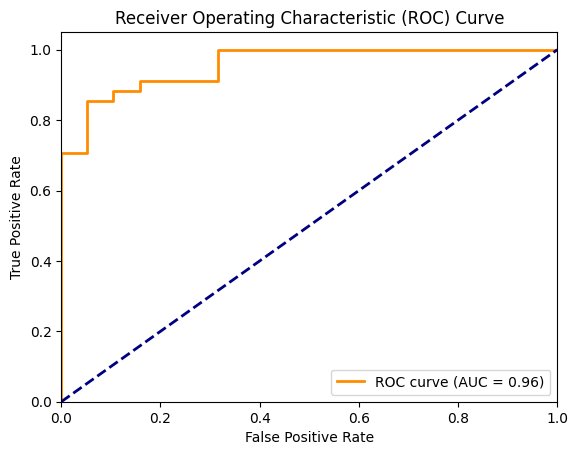

In [17]:
# Dla lasu losowego
args.model_type = "rf"
args.splits = 10
args.noise = 0
main(args)

args.noise = 0.1
main(args)

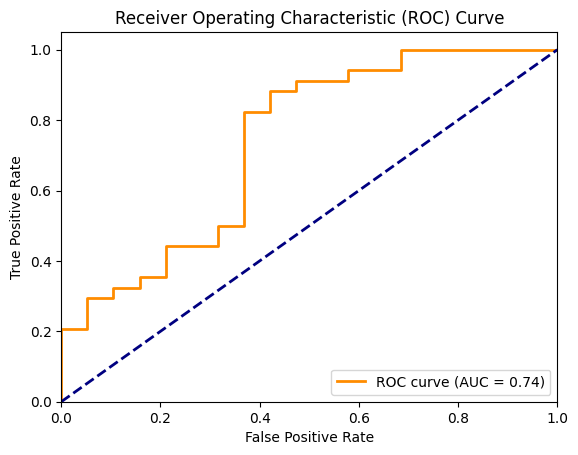

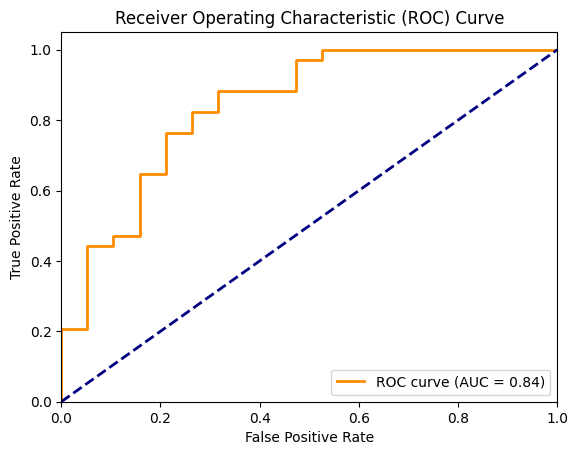

In [18]:
# Dla sieci neuronowej
args.model_type = "nn"
args.splits = 10
args.noise = 0
main(args)

args.noise = 0.1
main(args)

**WNIOSKI**<br>
Przeważnie podczas uczenia klasyfikatora jednoklasowego korzystamy z danych tylko dla jednej klasy. Często jednak zdarza się, że w danych uczących pojawiają się przykłady z klasy przeciwnej (anomalii). Zdarza się czasami, że takie zanieczyszczenie jest nawet wymagane, jak np. podczas nauki lasu izolacyjnego, gdzie musimy określić stopień zanieczyszczenia danych. Postanowiliśmy zbadać jego wpływ na osiągane przez nas wyniki. Zauważyliśmy, że zanieczyszczenie danych nie ma dużego wpływu na model bazujący na lasach losowych. Dla sieci neuronowej sytuacja wygląda zupełnie inaczej. Wynik dla zanieczyszczonego zbioru uczącego jest znacząco gorszy.

### Metryka wyboru najlepszych modeli (accuracy lub AUC)

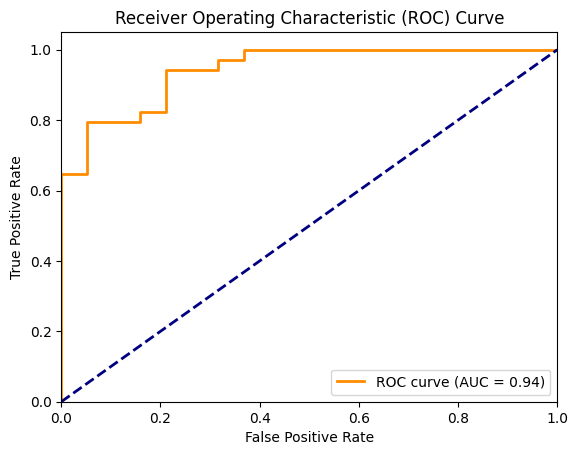

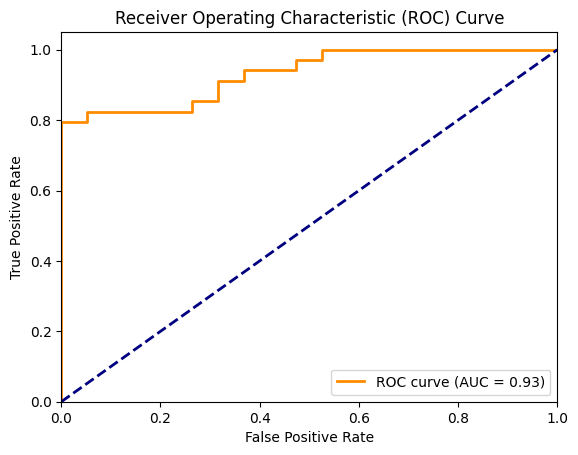

In [30]:
# Dla lasu losowego
args.model_type = "rf"
args.splits = 10
args.noise = 0.1
args.selection_metric = 'acc'
main(args)

args.selection_metric = 'auc'
main(args)

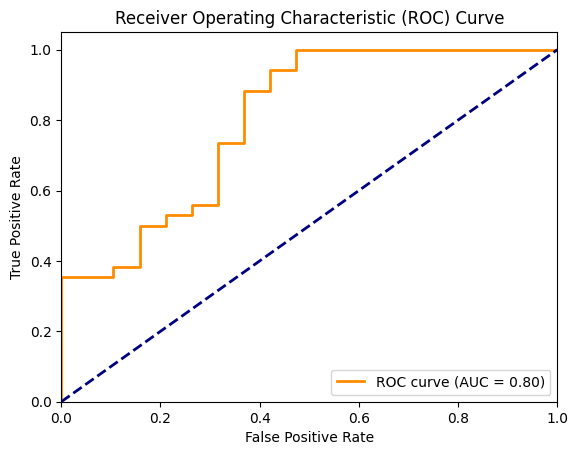

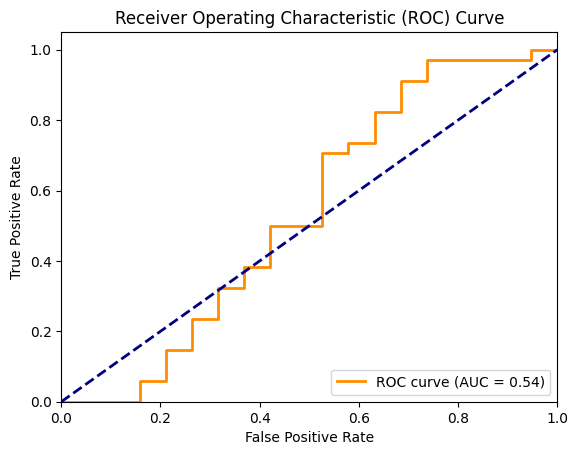

In [28]:
# Dla sieci neuronowej
args.model_type = "nn"
args.splits = 10
args.noise = 0.1
args.selection_metric = 'acc'
main(args)

args.selection_metric = 'auc'
main(args)

**WNIOSKI**<br>
Na podstawie powyższych wykresów, możemy stwierdzić, iż wybór metryki *ACCURACY* daje lepsze wyniki niż wybór metryki *AUC* do rankingowania najlepszych modeli. Nie są to bardzo znaczące różnice, w przypadku lasu losowego. Inaczej sytuacja prezentuje się przy sieci neuronowej, gdzie wyniki uzyskiwane przy użyciu *ACCURACY* są zdecydowanie lepsze, natomiast użycie w przypadku tej rodziny modeli metryki *AUC* do rankingowania powoduje bardzo słabe wyniki, zbliżone do losowych.

### Procent wyselekcjonowanych najlepszych modeli

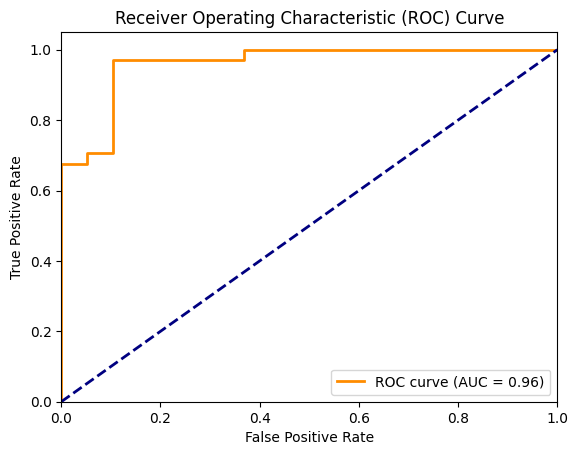

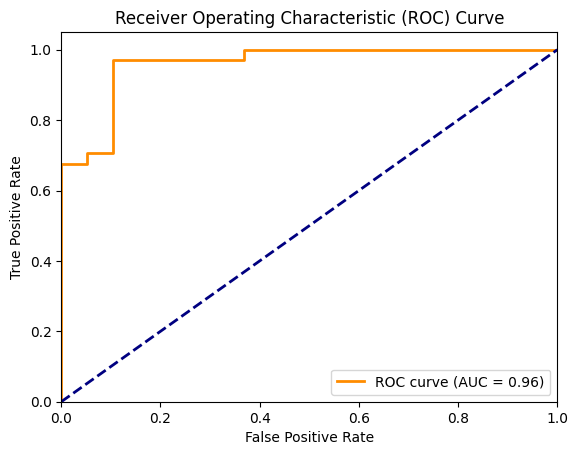

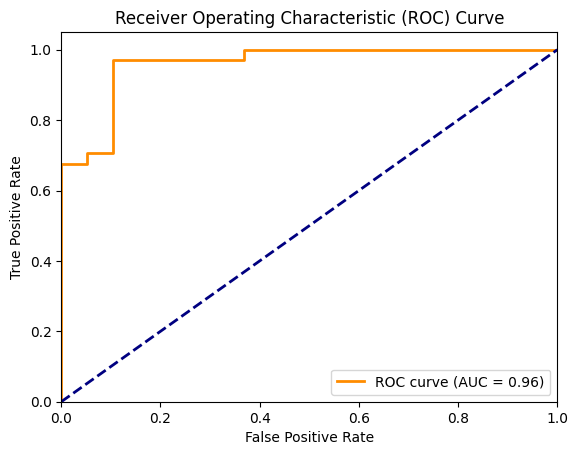

In [21]:
# Dla lasu losowego
args.model_type = "rf"
args.selection_metric = 'acc'
args.splits = 100
args.noise = 0

args.frac_models = 0.9
main(args)

args.frac_models = 0.5
main(args)

args.frac_models = 0.1
main(args)

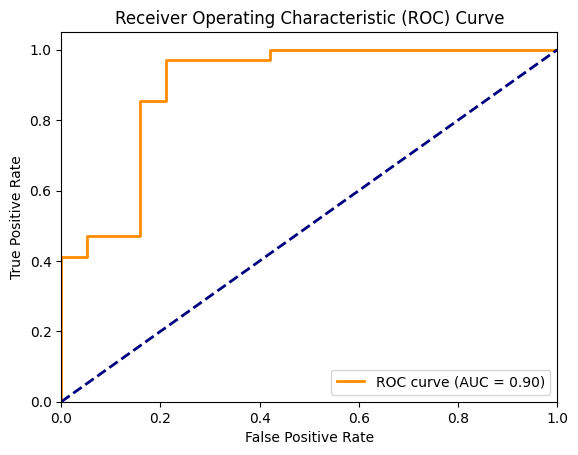

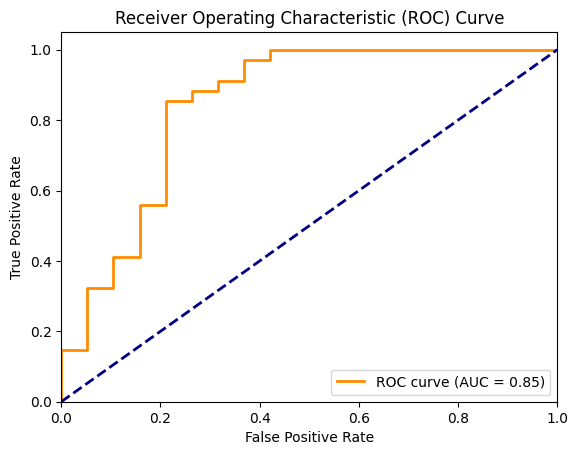

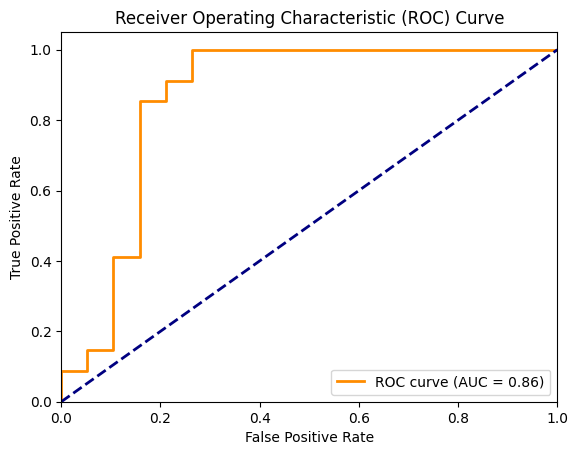

In [22]:
# Dla sieci neuronowej
args.model_type = "nn"
args.selection_metric = 'acc'
args.splits = 100
args.noise = 0

args.frac_models = 0.9
main(args)

args.frac_models = 0.5
main(args)

args.frac_models = 0.1
main(args)

**WNIOSKI**<br>
Selekcja podzbioru najlepszych modeli okazała się nie aż tak istotna, w przypadku lasu losowego. Różnica zuważalna jest w przypadku sieci neuronowych, gdzie pomiędzy wynikami uzyskanymi dla wykorzystania do predykcji 10%, 50% najlepszych modeli oraz dla wykorzystania 90% wynosi odpowiednio 5 i 4 punkty procentowe. Sugeruje to, że wybranie najbardziej elitarnych modeli nie wpływa korzystnie na wyniki sieci neuronowej, większy zysk daje zwiększenie liczby modeli użytych do ostatecznej predykcji.

### Porównanie naszego rozwiązania do istniejących metod (Las Izolacyjny oraz One-Class SVM)

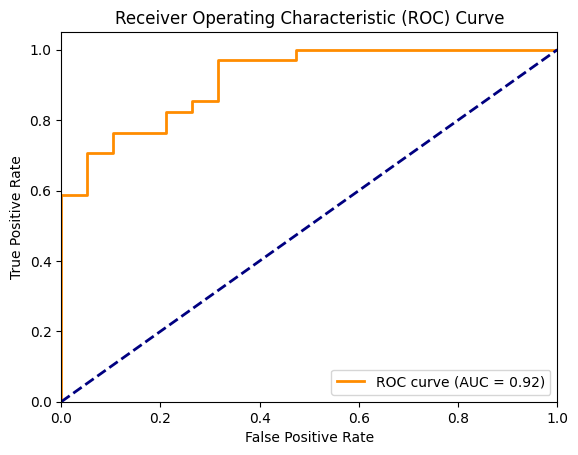

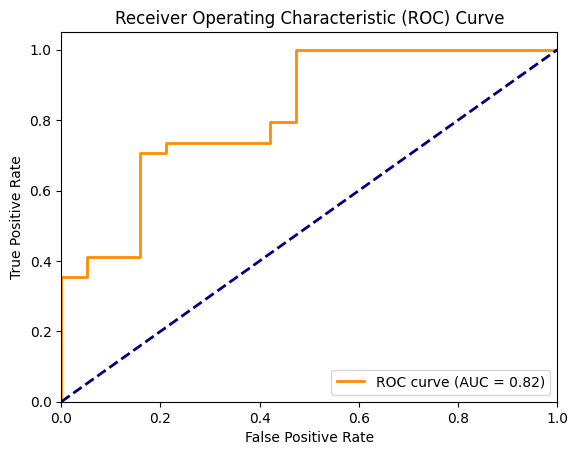

In [23]:
# Isolation Forest
args.model_type = "if"
args.noise = 0.1
main(args)

# One-Class SVM
args.model_type = "svm"
args.noise = 0.1
main(args)

**WNIOSKI**<br>
Na podstawie powyższych wykresów, możemy zauważyć, że las izolacyjny działa zdecydowanie lepiej niż jednoklasowy SVM. Las izolacyjny daje jedynie gorszy wynik, porównując go do najlepszego wyniku, gdzie zastosowaliśmy zespół lasów losowych. Nasze rozwiązanie daje minimalnie lepszy wynik. Mimo wszystko należy podkreślić to co pisaliśmy wcześniej, gdzie zastosowaliśmy pewne przybliżenie w celu liczenia AUC dla lasu izolacyjnego. Przybliżenie to zniekształca trochę wynik i musimy mieć to na uwadzę. Można więc z dużą dozą prawdopodobieństwa powiedzieć, że las izolacyjny daje mimo wszystko najlepsze wyniki, ale cieszy fakt, że zastosowana przez nas metoda może z nią konkurować.